In [1]:
import os
import json
import requests
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

from utils import draw_venn

# Load dataset

In [2]:
DATA_DIR = "../data"

In [3]:
chembl_df = pd.read_csv(f"{DATA_DIR}/processed/bacterial_chembl_33.tsv", sep="\t")
coadd_df = pd.read_csv(f"{DATA_DIR}/processed/bacterial_coadd.tsv", sep="\t")
spark_df = pd.read_csv(f"{DATA_DIR}/processed/bacterial_spark.tsv", sep="\t")

In [4]:
combined_df = pd.concat([chembl_df, coadd_df, spark_df], ignore_index=True)
combined_df.head()

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_33,5.0,5.0,NaN,6.0
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_33,NaN,NaN,6.0,NaN
2,OEFUWWDPRNNMRS-WDPNLORNSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4ccc...,chembl_33,6.0,6.5,NaN,NaN
3,LBRXTHSVIORIGU-OLROFJLRSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4cnc...,chembl_33,6.0,6.0,NaN,NaN
4,PHYLUFIYANLQSE-UHFFFAOYSA-N,CN1Cc2csc3c(C(=O)O)c(=O)c4cc(F)c(N5CCOC(CF)C5)...,chembl_33,7.5,7.0,NaN,NaN


In [5]:
combined_df["compound_source"].value_counts()

chembl_33              64881
spark                  15275
coadd_03_01-02-2020     4763
Name: compound_source, dtype: int64

In [6]:
combined_df["compound_inchikey"].nunique(), combined_df["compound_smiles"].nunique()

(77442, 84689)

# Looking for cross-database overlaps

In [7]:
chembl_cmpds = set(chembl_df["compound_inchikey"].unique())
coadd_cmpds = set(coadd_df["compound_inchikey"].unique())
spark_cmpds = set(spark_df["compound_inchikey"].unique())

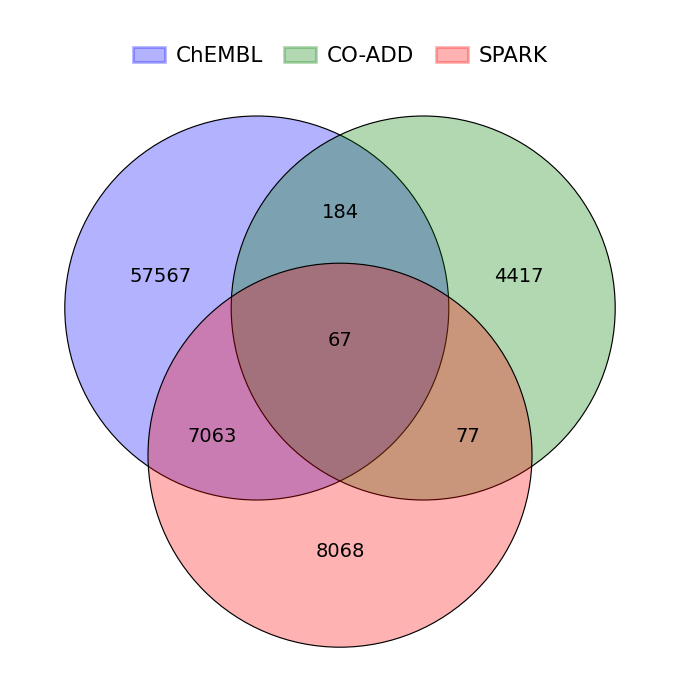

In [8]:
draw_venn(
    sets={"ChEMBL": chembl_cmpds, "CO-ADD": coadd_cmpds, "SPARK": spark_cmpds},
    save=True,
)

# Merging compound activities from different data resource

In [9]:
data = []

for inchikey in tqdm(combined_df["compound_inchikey"].unique()):
    if pd.isna(inchikey):
        continue

    tmp = combined_df[combined_df["compound_inchikey"] == inchikey]

    if len(tmp) == 1:
        data.append(tmp.to_dict(orient="records")[0])
    else:
        activity_data = tmp[["gram-positive", "gram-negative", "fungi", "acid-fast"]]

        # get median value column wise and if entry is NaN, then get the median of the non-NaN value
        activity_data = activity_data.fillna(activity_data.median()).median()
        data.append(
            {
                "compound_inchikey": inchikey,
                "compound_smiles": tmp["compound_smiles"].values[0],
                "compound_source": ", ".join(tmp["compound_source"].unique()),
                "gram-positive": activity_data["gram-positive"],
                "gram-negative": activity_data["gram-negative"],
                "fungi": activity_data["fungi"],
                "acid-fast": activity_data["acid-fast"],
            }
        )

  0%|          | 0/77443 [00:00<?, ?it/s]

100%|██████████| 77443/77443 [03:05<00:00, 416.48it/s]


In [10]:
final_df = pd.DataFrame(data)
final_df.head()

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_33,5.0,5.0,NaN,6.0
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_33,NaN,NaN,6.0,NaN
2,OEFUWWDPRNNMRS-WDPNLORNSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4ccc...,chembl_33,6.0,6.5,NaN,NaN
3,LBRXTHSVIORIGU-OLROFJLRSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4cnc...,chembl_33,6.0,6.0,NaN,NaN
4,PHYLUFIYANLQSE-UHFFFAOYSA-N,CN1Cc2csc3c(C(=O)O)c(=O)c4cc(F)c(N5CCOC(CF)C5)...,chembl_33,7.5,7.0,NaN,NaN


In [11]:
combined_df.shape, final_df.shape

((84919, 7), (77442, 7))

In [12]:
final_df["compound_inchikey"].nunique(), final_df["compound_smiles"].nunique()

(77442, 77442)

# Find chemical classes

In [13]:
CLASSIFIER_URL = "https://npclassifier.ucsd.edu/classify?smiles="

In [14]:
def get_chemical_class(smiles_string):
    structure_class = requests.get(CLASSIFIER_URL + smiles_string)
    if structure_class.status_code == 200:
        data_dict = structure_class.json()
        return {
            i: j
            for i, j in data_dict.items()
            if i in ["class_results", "superclass_results", "pathway_results"]
        }
    else:
        return None

In [15]:
if os.path.exists(f"{DATA_DIR}/mapping/structure2class.json"):
    with open(f"{DATA_DIR}/mapping/structure2class.json", "r") as f:
        structure_classes = json.load(f)
else:
    structure_classes = {}

In [16]:
skipped = set()

c = 0
for smiles in tqdm(final_df["compound_smiles"].unique()):
    if smiles in structure_classes or smiles in skipped:
        continue

    structure_classes[smiles] = get_chemical_class(smiles)
    c += 1

    if c == 50:
        # caching the results
        with open(f"{DATA_DIR}/mapping/structure2class.json", "w") as f:
            json.dump(structure_classes, f, ensure_ascii=False, indent=4)
        c = 0

100%|██████████| 77442/77442 [00:00<00:00, 4427266.90it/s]


In [17]:
len(skipped), len(structure_classes)

(0, 77442)

In [18]:
# caching the results
with open(f"{DATA_DIR}/mapping/structure2class.json", "w") as f:
    json.dump(structure_classes, f, ensure_ascii=False, indent=4)

# Adding chemical characterstics to the table

In [19]:
cmpd_classes = []
cmpd_superclasses = []
cmpd_pathways = []

for smiles in tqdm(final_df["compound_smiles"], total=len(final_df)):
    if smiles in structure_classes:
        if structure_classes[smiles]:
            cmpd_classes.append(structure_classes[smiles]["class_results"])
            cmpd_superclasses.append(structure_classes[smiles]["superclass_results"])
            cmpd_pathways.append(structure_classes[smiles]["pathway_results"])
        else:
            cmpd_classes.append(None)
            cmpd_superclasses.append(None)
            cmpd_pathways.append(None)
    else:
        cmpd_classes.append(None)
        cmpd_superclasses.append(None)
        cmpd_pathways.append(None)

100%|██████████| 77442/77442 [00:00<00:00, 2340353.27it/s]


In [20]:
final_df["chemical_class"] = cmpd_classes
final_df["compound_superclass"] = cmpd_superclasses
final_df["compound_pathway"] = cmpd_pathways

# Max value based approach for categorization

In [21]:
best_classes = []

for gram_pos, gram_neg, fungi, acid_fast in zip(
    final_df["gram-positive"],
    final_df["gram-negative"],
    final_df["fungi"],
    final_df["acid-fast"],
):
    # if any of the values are NaN, then set them to 0
    if pd.isna(gram_pos):
        gram_pos = 0
    if pd.isna(gram_neg):
        gram_neg = 0
    if pd.isna(fungi):
        fungi = 0
    if pd.isna(acid_fast):
        acid_fast = 0

    max_bact = max(gram_pos, gram_neg, acid_fast)

    if max_bact < fungi:
        best_classes.append("fungi")
    else:
        if max_bact == gram_pos:
            best_classes.append("gram-positive")
        elif max_bact == gram_neg:
            best_classes.append("gram-negative")
        else:
            best_classes.append("acid-fast")

final_df["best_class"] = best_classes

In [22]:
final_df["best_class"].value_counts()

gram-positive    43012
gram-negative    16235
fungi             9167
acid-fast         9028
Name: best_class, dtype: int64

In [23]:
final_df.head(2)

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast,chemical_class,compound_superclass,compound_pathway,best_class
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_33,5.0,5.0,NaN,6.0,"[Amino cyclitols, Aminoglycosides]","[Aminosugars and aminoglycosides, Polyols]",[Carbohydrates],acid-fast
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_33,NaN,NaN,6.0,NaN,[Chalcones],[Flavonoids],[Shikimates and Phenylpropanoids],fungi


# Visualizing distribution for pChEMBL

In [24]:
pchem_dist_dict = defaultdict(list)

for idx, row in tqdm(final_df.iterrows(), total=len(final_df)):
    (
        inchikey,
        smiles,
        source,
        gram_pos,
        gram_neg,
        fungi,
        acid_fast,
        _,
        _,
        _,
        best_class,
    ) = row

    if best_class == "gram-positive":
        pchem_dist_dict["gram-positive"].append(gram_pos)

    elif best_class == "gram-negative":
        pchem_dist_dict["gram-negative"].append(gram_neg)

    elif best_class == "fungi":
        pchem_dist_dict["fungi"].append(fungi)

    elif best_class == "acid-fast":
        pchem_dist_dict["acid-fast"].append(acid_fast)

100%|██████████| 77442/77442 [00:00<00:00, 83877.78it/s]


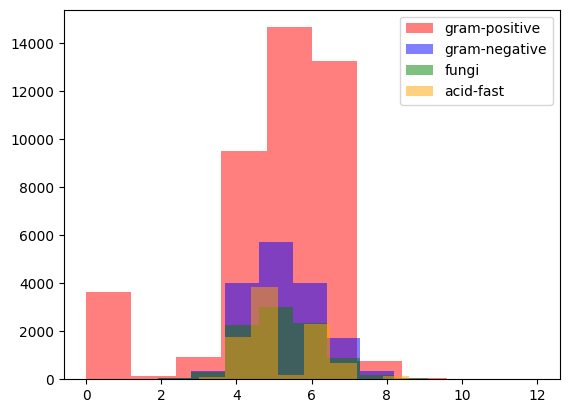

In [25]:
plt.hist(
    pchem_dist_dict["gram-positive"], alpha=0.5, color="red", label="gram-positive"
)
plt.hist(
    pchem_dist_dict["gram-negative"], alpha=0.5, color="blue", label="gram-negative"
)
plt.hist(pchem_dist_dict["fungi"], alpha=0.5, color="green", label="fungi")
plt.hist(pchem_dist_dict["acid-fast"], alpha=0.5, color="orange", label="acid-fast")
plt.legend()
plt.savefig(f"../figures/compound_activity_distribution.png")
plt.show()

In [26]:
final_df.to_csv(
    f"{DATA_DIR}/processed/combined_bioassay_data.tsv", sep="\t", index=False
)